## Imports and Prelims

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np 
import sympy as sy 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from copy import deepcopy
from positionedpogos.math import (calculate_jacobian_symmetric_difference,
calculate_jacobian_forward_difference, calculate_jacobian_backward_difference)
from positionedpogos.controllers import QuadrotorLQR
from positionedpogos.plants import ClosedLoopPlanarQuadrotor

# Laying the foundation for drone sim

We are going to attempt a similar inverse kinematics approach to the planar quadrotor problem. For starters, we can import relevant functions for the quadrotor, develop a simple plotting function, and show some basic results. 

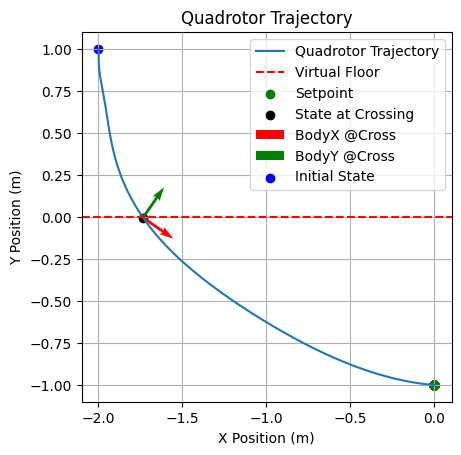

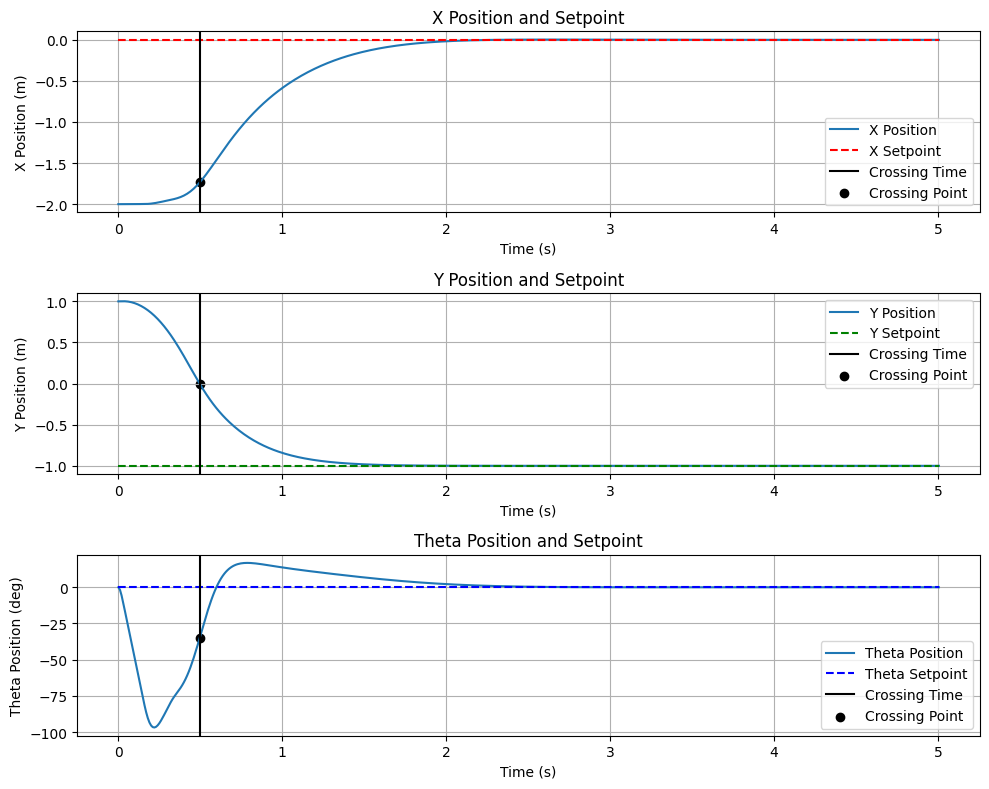

In [51]:
from positionedpogos.optimization import execute_single_trial
from positionedpogos.visualizations import visualize_single_trial
# Try a sample setup to see if everything is working correctly 
origin = np.array([-2, 1, 0, 0, 0, 0]) # Positioned at (-2, 1), at a hover
target = np.array([0, -1, 0, 0, 0, 0]) # -1 below (0, 0), no velocity 
thresh = 1 # Virtual floor is one unit below the starting point

# Now run the trial 
clpqr = execute_single_trial(origin, target, thresh) 

# And see if we can plot results 
visualize_single_trial(clpqr)

# In-Depth Examinations of the Search Space

Next, we can take a look at different representations of the overall search space. To do this, we can form a series of waypoints that encapsualates the area we'd like to search, and then perform analysis. Let's start by creating a set of waypoints and plotting them. 

In [52]:
# Gaussian distribution 
means = np.array([2.5, -2.6]) 
sigmas = np.array([[0.4, 0,], [0, 0.4]]) 
search_space = np.random.multivariate_normal(means, sigmas, size=1000) 

In [53]:
search_space

array([[ 2.36233648, -3.02669724],
       [ 2.35675816, -2.44561161],
       [ 2.89330878, -2.72159743],
       ...,
       [ 2.92333583, -2.79687787],
       [ 2.82885003, -3.61002882],
       [ 1.78486595, -3.10068687]])

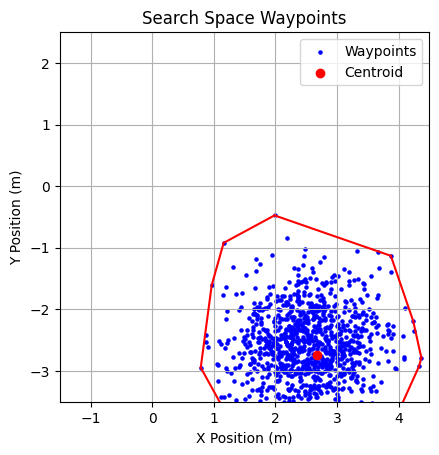

In [54]:
from positionedpogos.visualizations import visualize_search_space_points
visualize_search_space_points(search_space)

In [68]:
# Grid search 
from positionedpogos.optimization import generate_grid 
x_limits = (-1, 3) 
y_limits = (-5.5, -1.5) 
num_x_points = 40
num_y_points = 40

search_space = generate_grid(x_limits, y_limits, num_x_points, num_y_points) 

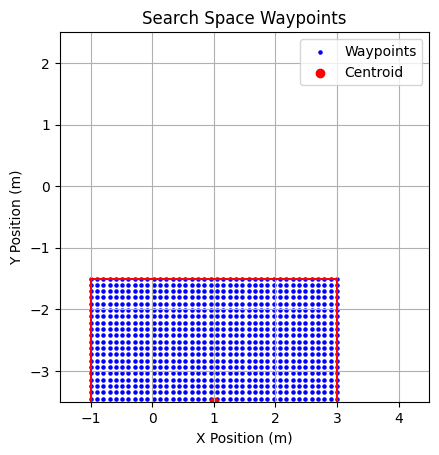

In [69]:
visualize_search_space_points(search_space)

Now we can see the outputs over this search space, and generate some 3D plots

In [70]:
# Execute the simulations 
origin = np.array([-2, 1, 6, 0, 0, 0]) # Positioned at (-2, 1), with 6 m/s of initial velocity
simulations = []

# Add 0s to the points to represent pitch + 3 velocities
targets = np.hstack((search_space, np.zeros((len(search_space), 4))))
thresh = 1

for i in tqdm(range(len(targets)), desc="Executing trajectories"): 
    simulations.append(execute_single_trial(origin, targets[i], thresh))

Executing trajectories:   0%|          | 0/1600 [00:00<?, ?it/s]

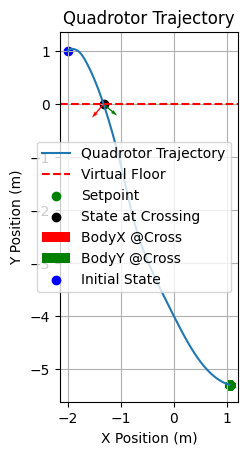

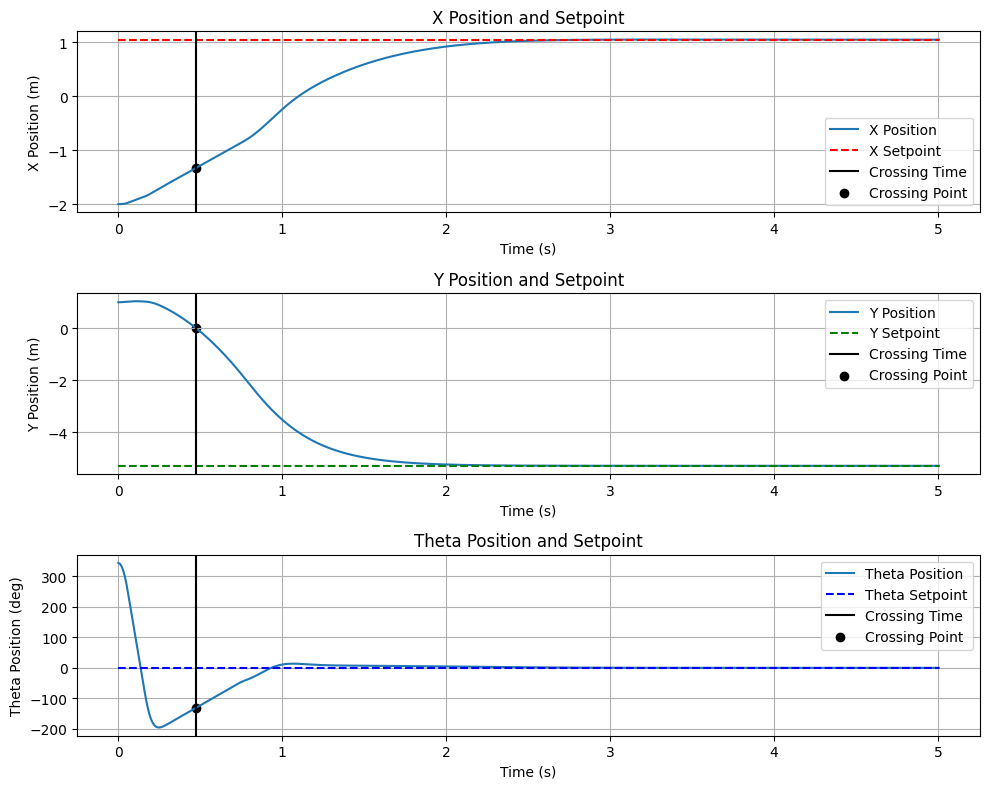

In [72]:
# Now we can take a look at some of these trajectories
visualize_single_trial(simulations[100]) 

In [73]:
# We need to collect results over the search space 
task_space_results = np.zeros((len(targets), 2))

simulation_data_logs = [s.get_data_log() for s in simulations]

for i, log in enumerate(simulation_data_logs): 
    task_space_results[i, :] = log['state_at_crossing'][[0, 2]]

# Let's see some results 
task_space_results[0:2]

array([[-1.17207399, -0.23985802],
       [-1.17319992, -0.31769491]])

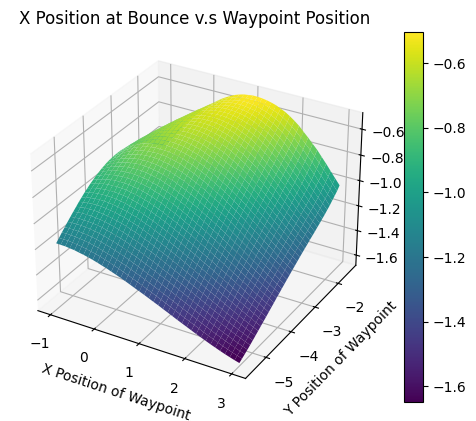

In [74]:
# Now let's generate some 3D plots
from mpl_toolkits.mplot3d import Axes3D
import pickle 

grid_x, grid_y = np.unique(targets[:, 0]), np.unique(targets[:, 1]) 

# Reshape Z for potting
position_results_reshaped = task_space_results[:, 0].reshape(len(grid_y), len(grid_x))
angle_results_reshaped = np.degrees(task_space_results[:, 1].reshape(len(grid_y), len(grid_x)))

mesh_x, mesh_y = np.meshgrid(grid_x, grid_y)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
surf = ax.plot_surface(mesh_x, mesh_y, position_results_reshaped, cmap='viridis')
ax.set_xlabel('X Position of Waypoint') 
ax.set_ylabel('Y Position of Waypoint') 
ax.set_zlabel('X Position at Bounce') 
ax.set_title("X Position at Bounce v.s Waypoint Position") 
plt.colorbar(surf) 
plt.show() 

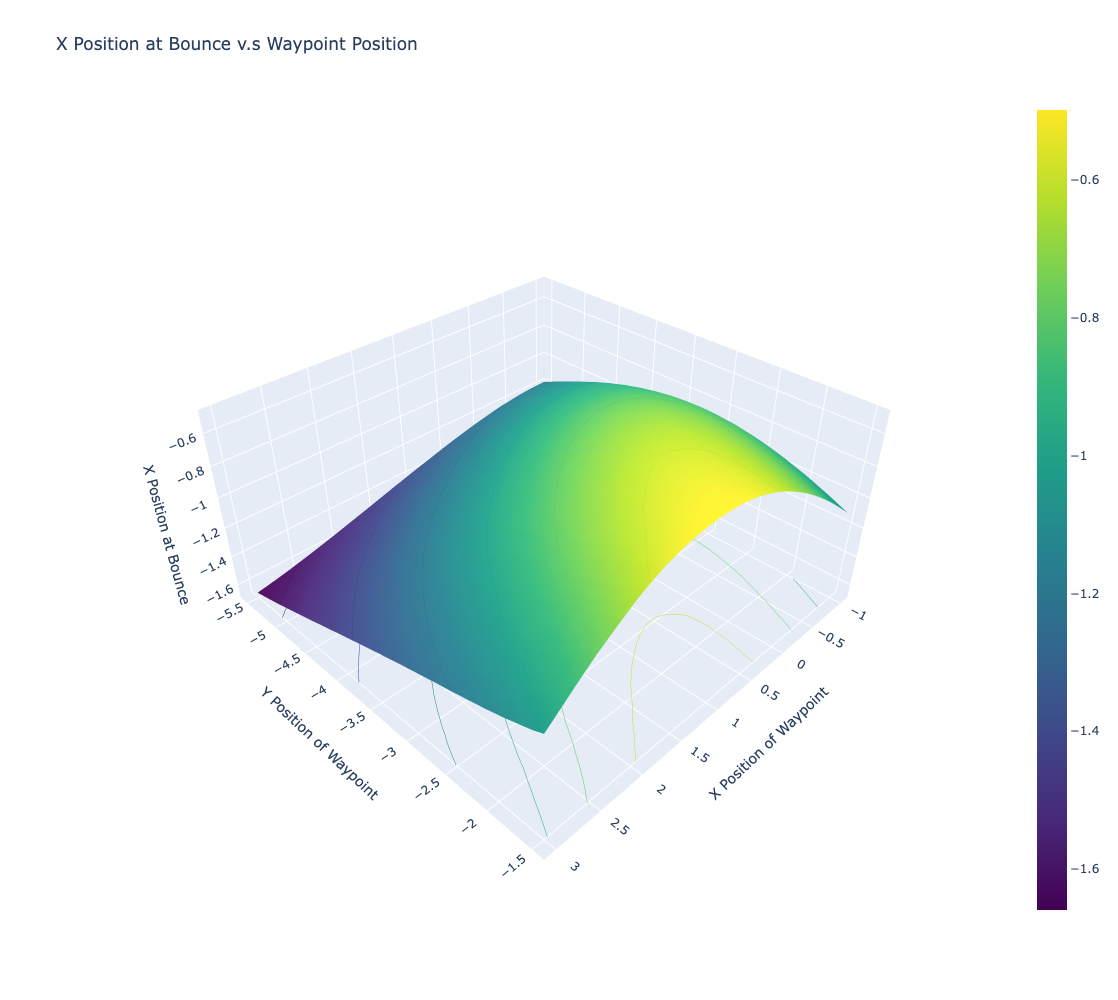

In [75]:
import plotly.graph_objects as go


# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=position_results_reshaped, x=mesh_x, y=mesh_y, colorscale='Viridis',
    contours={'z': {'show': True, 'usecolormap': True, 'highlightcolor': "limegreen", 'project_z': True}},
    hoverinfo='x+y+z',  # Specify which variables to include in hover
    hovertemplate='Waypoint X = %{x} [meters] <br>Waypoint Y = %{y} [meters] <br>X Position at Bounce = %{z} [meters] <extra></extra>'
)])

fig.update_layout(
    title='X Position at Bounce v.s Waypoint Position',
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis_title='X Position of Waypoint',
        yaxis_title='Y Position of Waypoint',
        zaxis_title='X Position at Bounce'
    ),
    width=1000, height=1000
)


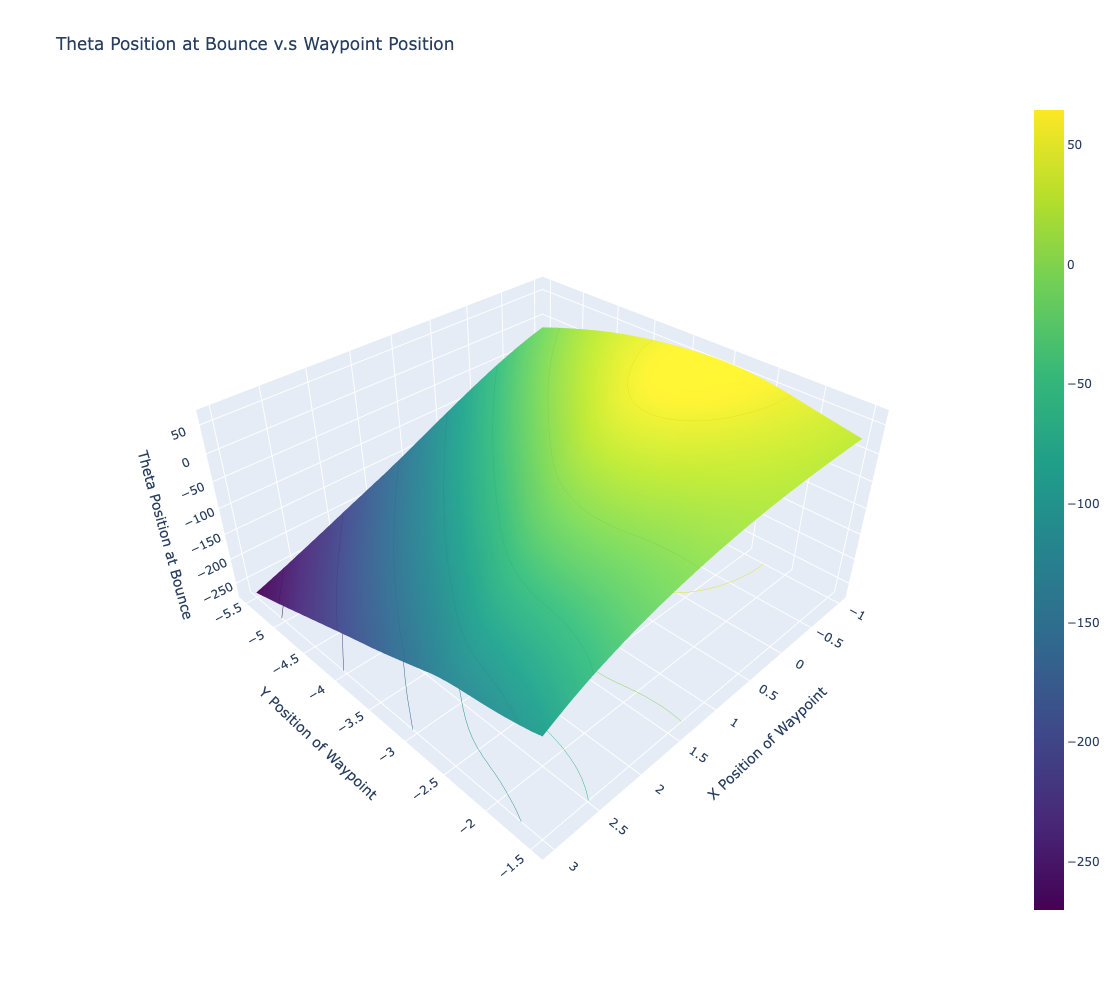

In [76]:
# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=angle_results_reshaped, x=mesh_x, y=mesh_y, colorscale='Viridis',
    contours={'z': {'show': True, 'usecolormap': True, 'highlightcolor': "limegreen", 'project_z': True}},
    hoverinfo='x+y+z',  # Specify which variables to include in hover
    hovertemplate='Waypoint X = %{x} [meters] <br>Waypoint Y = %{y} [meters] <br>X Theta at Bounce = %{z} [deg] <extra></extra>'
)])


fig.update_layout(
    title='Theta Position at Bounce v.s Waypoint Position',
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis_title='X Position of Waypoint',
        yaxis_title='Y Position of Waypoint',
        zaxis_title='Theta Position at Bounce'
    ),
    width=1000, height=1000
)

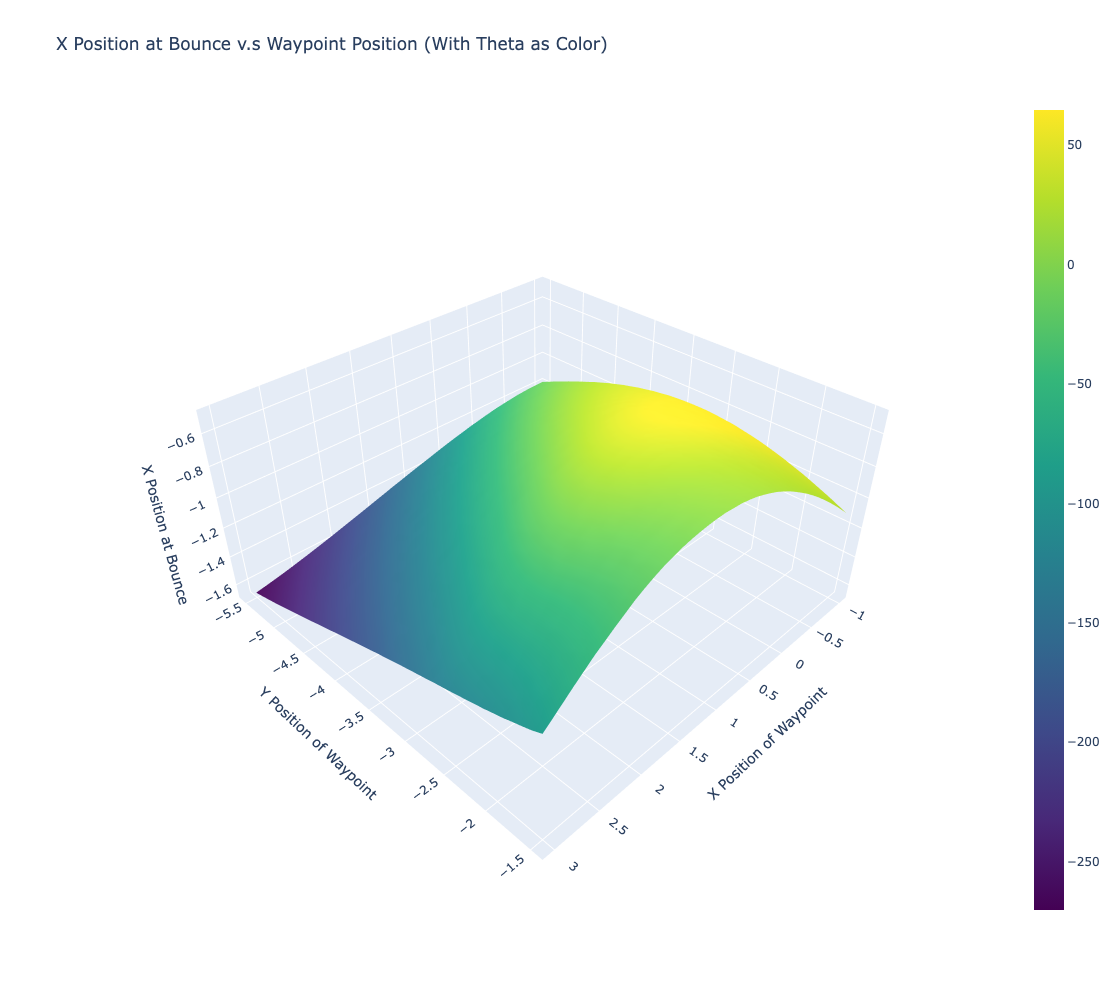

In [77]:
# Create the 3D surface plot
hover_text = np.vectorize(lambda x, y, z, angle: f'Waypoint X = {x}<br>Waypoint Y = {y}<br>X Position at Bounce = {z}<br>Angle = {angle}')(
    mesh_x, mesh_y, position_results_reshaped, angle_results_reshaped)

fig = go.Figure(data=[go.Surface(
    z=position_results_reshaped,  # Heights are controlled by position results
    x=mesh_x, 
    y=mesh_y, 
    surfacecolor=angle_results_reshaped,  # Colors are controlled by angle results
    colorscale='Viridis',
    text=hover_text,
    hoverinfo='text'
)])

fig.update_layout(
    title='X Position at Bounce v.s Waypoint Position (With Theta as Color)',
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis_title='X Position of Waypoint',
        yaxis_title='Y Position of Waypoint',
        zaxis_title='X Position at Bounce'
    ),
    width=1000, height=1000, 
    coloraxis_colorbar=dict(
        title='Angle'  # Colorbar title for angle results
    )
)


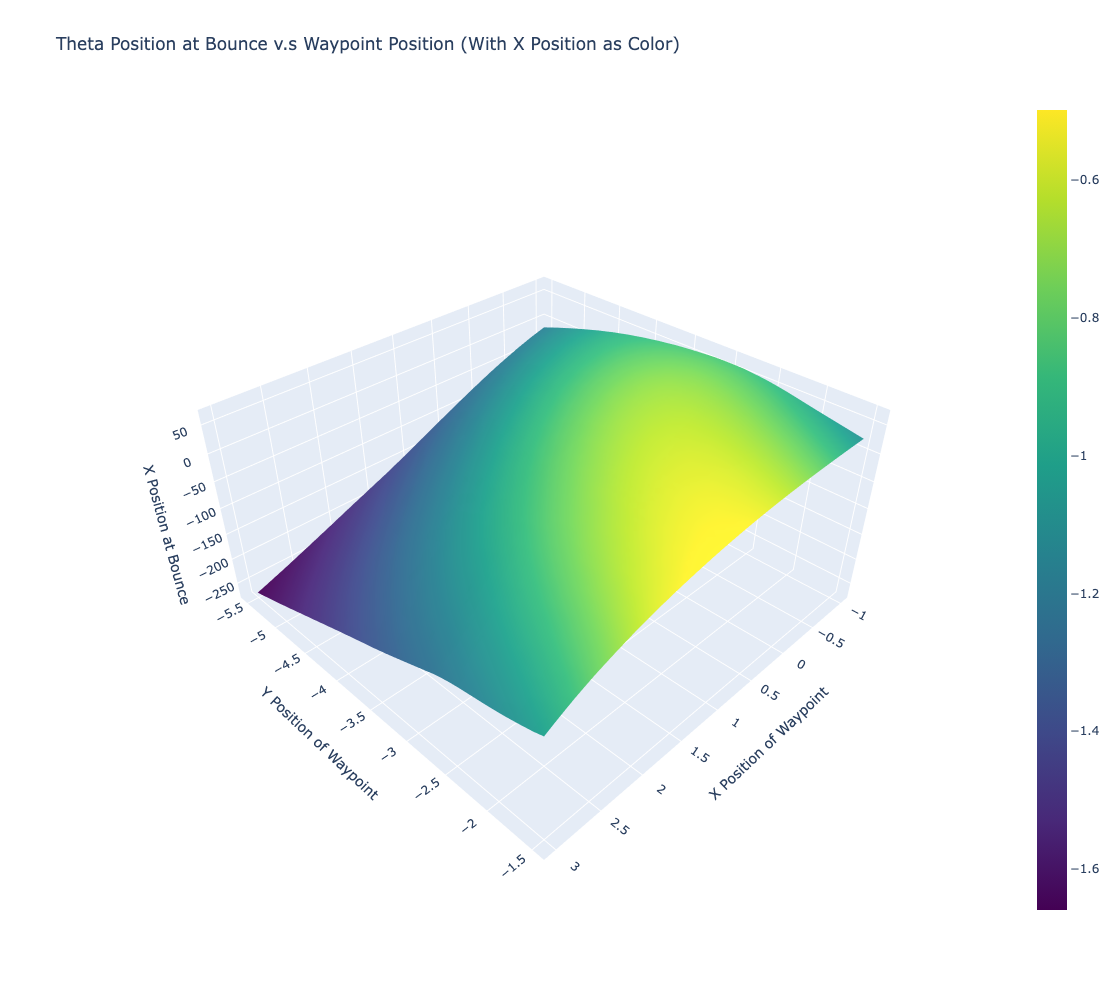

In [78]:
# Create the 3D surface plot
hover_text = np.vectorize(lambda x, y, z, angle: f'Waypoint X = {x}<br>Waypoint Y = {y}<br>X Position at Bounce = {z}<br>Angle = {angle}')(
    mesh_x, mesh_y, position_results_reshaped, angle_results_reshaped)

fig = go.Figure(data=[go.Surface(
    z=angle_results_reshaped,  # Heights are controlled by position results
    x=mesh_x, 
    y=mesh_y, 
    surfacecolor=position_results_reshaped,  # Colors are controlled by angle results
    colorscale='Viridis',
    text=hover_text,
    hoverinfo='text'
)])

fig.update_layout(
    title='Theta Position at Bounce v.s Waypoint Position (With X Position as Color)',
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis_title='X Position of Waypoint',
        yaxis_title='Y Position of Waypoint',
        zaxis_title='X Position at Bounce'
    ),
    width=1000, height=1000, 
    coloraxis_colorbar=dict(
        title='Angle'  # Colorbar title for angle results
    )
)

Now let's visualize the loss function over this search space for an arbitrary bounce condition. Let's say an incident angle of 10 degrees, and a bounce that happens 1m in front of the initial point, which for this demo is at X = -1

(40, 40)
(40, 40)


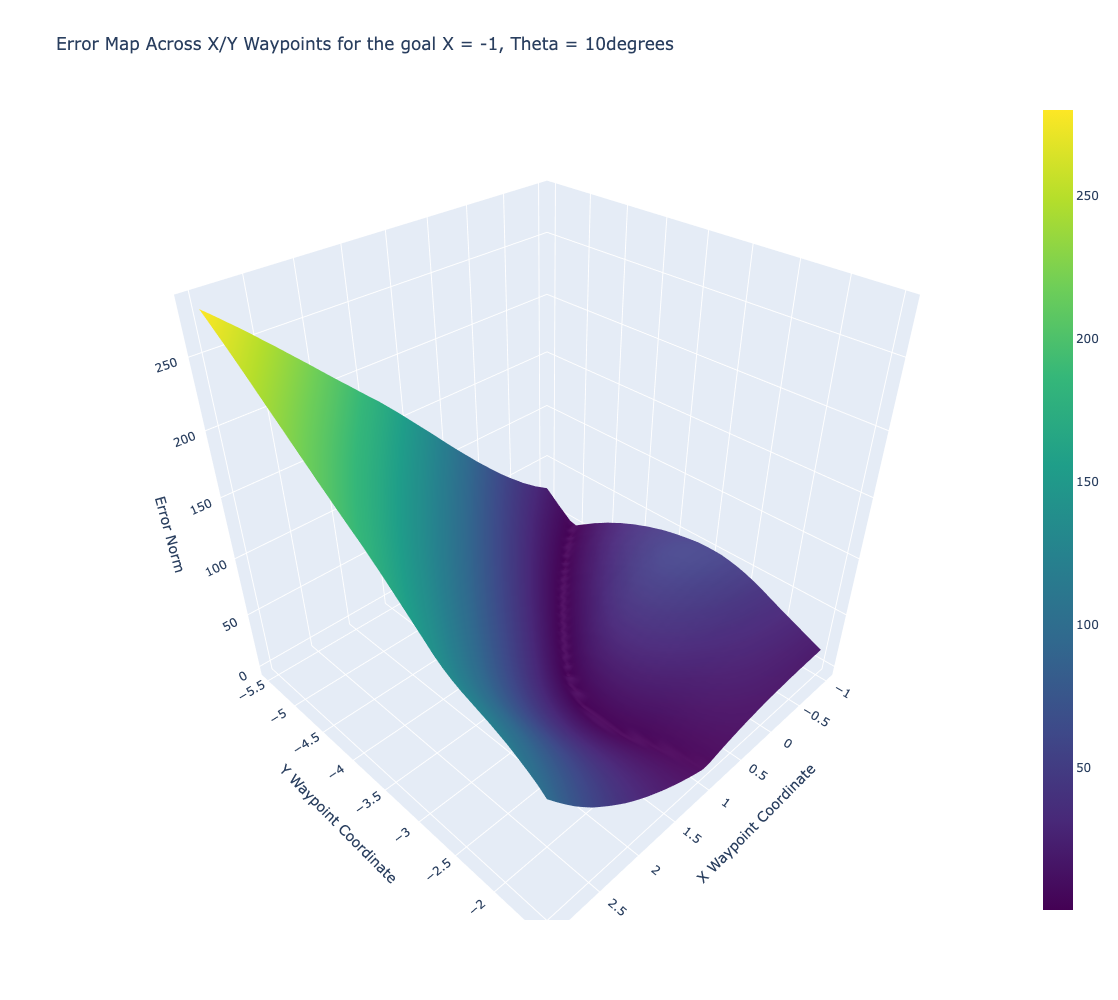

In [79]:
goal_position = -1
goal_angle = 10

error_norms = np.sqrt((position_results_reshaped - goal_position)**2 + (angle_results_reshaped - goal_angle)**2)

print(error_norms.shape) 
print(position_results_reshaped.shape) 

# Create the 3D surface plot for the error norms
fig = go.Figure(data=[go.Surface(
    z=error_norms, x=mesh_x, y=mesh_y, colorscale='Viridis',
    hoverinfo='x+y+z',
    hovertemplate='X = %{x}<br>Y = %{y}<br>Error Norm = %{z}<extra></extra>'
)])

# Update layout
fig.update_layout(
    title='Error Map Across X/Y Waypoints for the goal X = -1, Theta = 10degrees',
    scene=dict(
        xaxis_title='X Waypoint Coordinate',
        yaxis_title='Y Waypoint Coordinate',
        zaxis_title='Error Norm'
    ),
    width=1000, height=1000
)

fig.show()

(40, 40)
(40, 40)


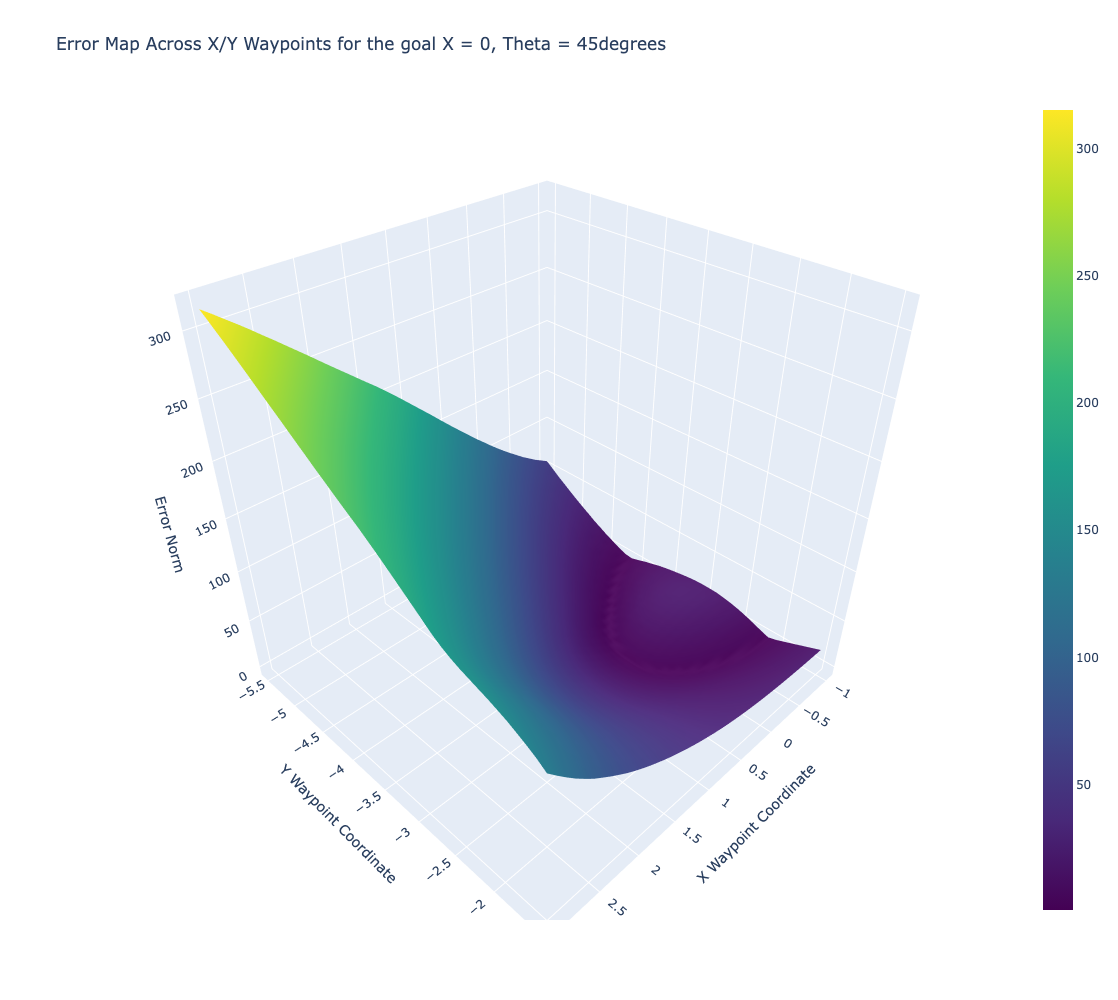

In [80]:
goal_position = 0
goal_angle = 45

error_norms = np.sqrt((position_results_reshaped - goal_position)**2 + (angle_results_reshaped - goal_angle)**2)

print(error_norms.shape) 
print(position_results_reshaped.shape) 

# Create the 3D surface plot for the error norms
fig = go.Figure(data=[go.Surface(
    z=error_norms, x=mesh_x, y=mesh_y, colorscale='Viridis',
    hoverinfo='x+y+z',
    hovertemplate='X = %{x}<br>Y = %{y}<br>Error Norm = %{z}<extra></extra>'
)])

# Update layout
fig.update_layout(
    title='Error Map Across X/Y Waypoints for the goal X = 0, Theta = 45degrees',
    scene=dict(
        xaxis_title='X Waypoint Coordinate',
        yaxis_title='Y Waypoint Coordinate',
        zaxis_title='Error Norm'
    ),
    width=1000, height=1000
)

fig.show()